Library and Token Setup

In [1]:
!pip install pandas langchain_community replicate -q

import pandas as pd
import os
import time
from google.colab import userdata
from langchain_community.llms import Replicate

# API TOKEN SETUP

try:
    api_token = userdata.get('CapstoneProject')
    os.environ["REPLICATE_API_TOKEN"] = api_token

    model_identifier =  "ibm-granite/granite-3.3-8b-instruct"
    llm = Replicate(
        model=model_identifier,
        model_kwargs={"temperature": 0.7, "max_new_tokens": 256}
    )
    print(f"Model '{model_identifier}' sukses.")

except Exception as e:
    print(f"Error : {e}")
    llm = None



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
Model 'ibm-granite/granite-3.3-8b-instruct' sukses.


Load and Clean Dataset

In [2]:
if llm:
    try:
        print("\nMemuat dan membersihkan 'News Dataset.csv'...")
        df = pd.read_csv('News Dataset.csv')

        # Menghapus baris yang tidak memiliki konten d'
        df.dropna(subset=['content'], inplace=True)
        df = df[df['content'].str.strip() != '[Removed]']
        df = df[df['content'].str.strip() != 'removed']

        # Test pada 10 baris pertama.
        df_sample = df.head(10).copy()

        print(f"Dataset berhasil dimuat. {len(df_sample)} berita.")
        print("Judul berita yang akan dianalisis:", df_sample.iloc[0]['title'])

    except FileNotFoundError:
        print("\nError: File 'News Dataset.csv' tidak ditemukan.")
        print("Mohon pastikan Anda sudah mengunggah file tersebut ke lingkungan Colab.")
        df_sample = None
    except Exception as e:
        print(f"\nTerjadi error saat memuat data: {e}")
        df_sample = None
else:
    df_sample = None
    print("\nProses tidak dapat dilanjutkan karena model AI gagal dikonfigurasi.")


Memuat dan membersihkan 'News Dataset.csv'...
Dataset berhasil dimuat. 10 berita.
Judul berita yang akan dianalisis: test-setcion


IBM GRANITE MODEL TEST

In [3]:
if df_sample is not None and llm is not None:
    def classify_sentiment(content: str) -> str:
        """
        Mengirimkan teks ke model AI untuk diklasifikasikan sentimennya.
        """
        prompt = f"""
        Classify the sentiment of the following news text as 'Positive', 'Negative', or 'Neutral'.
        Provide only the single-word classification as your answer.

        News Text: "{content}"

        Sentiment:
        """
        try:
            response = llm.invoke(prompt)
            return response.strip()
        except Exception as e:
            return f"Error: {e}"

    def summarize_text(content: str) -> str:
        """
        Mengirimkan teks ke model AI untuk dibuat ringkasannya.
        """
        prompt = f"""
        Provide a concise, one-paragraph summary of the following news text.

        News Text: "{content}"

        Summary:
        """
        try:
            response = llm.invoke(prompt)
            return response.strip()
        except Exception as e:
            return f"Error: {e}"

if df_sample is not None and llm is not None:
    print("\nMemulai proses analisis (Klasifikasi & Peringkasan)...")
    print("Proses ini mungkin memakan waktu beberapa menit tergantung jumlah data.")

    # Membuat list kosong untuk menampung hasil
    sentiments = []
    summaries = []

    # Menggunakan iterrows untuk perulangan dengan jeda untuk menghindari rate limit API
    for index, row in df_sample.iterrows():
        print(f"Menganalisis berita ke-{index + 1}...")

        # Analisis Sentimen
        sentiment_result = classify_sentiment(row['content'])
        sentiments.append(sentiment_result)

        # Peringkasan Teks
        summary_result = summarize_text(row['content'])
        summaries.append(summary_result)

        time.sleep(1) # Memberi jeda 1 detik antar request API

    # Menambahkan hasil ke DataFrame
    df_sample['sentiment'] = sentiments
    df_sample['summary'] = summaries

    print("\nAnalisis Selesai!")


Memulai proses analisis (Klasifikasi & Peringkasan)...
Proses ini mungkin memakan waktu beberapa menit tergantung jumlah data.
Menganalisis berita ke-1...
Menganalisis berita ke-2...
Menganalisis berita ke-3...
Menganalisis berita ke-4...
Menganalisis berita ke-6...
Menganalisis berita ke-7...
Menganalisis berita ke-8...
Menganalisis berita ke-9...
Menganalisis berita ke-10...
Menganalisis berita ke-13...

Analisis Selesai!


Output Model

In [5]:
    # Menampilkan kolom-kolom penting
    display(df_sample[['title', 'category', 'sentiment', 'summary']])

    # Menyimpan hasil ke file CSV baru
    output_filename = 'News_Analysis_Results.csv'
    df_sample.to_csv(output_filename, index=False)
    print(f"\nHasil lengkap telah disimpan ke dalam file '{output_filename}'.")

,title,category,sentiment,summary
0,test-setcion,technology,Neutral,The news text indicates that a certain platfor...
1,Don’t Let Mistrust of Tech Companies Blind You...,technology,Neutral,At the dawn of artificial intelligence (AI) as...
2,OpenAI Offers a Peek Inside the Guts of ChatGPT,technology,Negative,"OpenAI, the developer of ChatGPT, is under scr..."
3,The Rebirth of Queer Cruising Apps,technology,Neutral,In the wee hours of a night following February...
5,Internal Emails Show How a Controversial Gun-D...,technology,Neutral,Former NYPD members Adam and Banks reunited wi...
6,Nokia just made the first phone call using 3D ...,technology,Neutral,"The news indicates that Click Accept, a platfo..."
7,OpenAI Unveils GPT-4 Omni’s Voice Capabilities...,technology,Positive,"OpenAI unveiled its latest flagship model, GPT..."
8,Windows Is Getting Its Own AI Upscaler That Pr...,technology,Positive,Microsoft is integrating AI upscaling technolo...
9,"Alexa Will Get an Upgrade But It'll Cost You, ...",technology,Neutral,Amazon is reportedly planning to launch a gene...
12,Micro LED monitors connect like puzzle pieces ...,technology,Positive,In a technical disclosure published last month...



Hasil lengkap telah disimpan ke dalam file 'News_Analysis_Results.csv'.


Insight Findings


Memulai tahap analisis hasil untuk menemukan insight...

--- Insight & Findings ---

1. Distribusi Sentimen dari Sampel Berita:
sentiment
Neutral     6
Positive    3
Negative    1
Name: count, dtype: int64


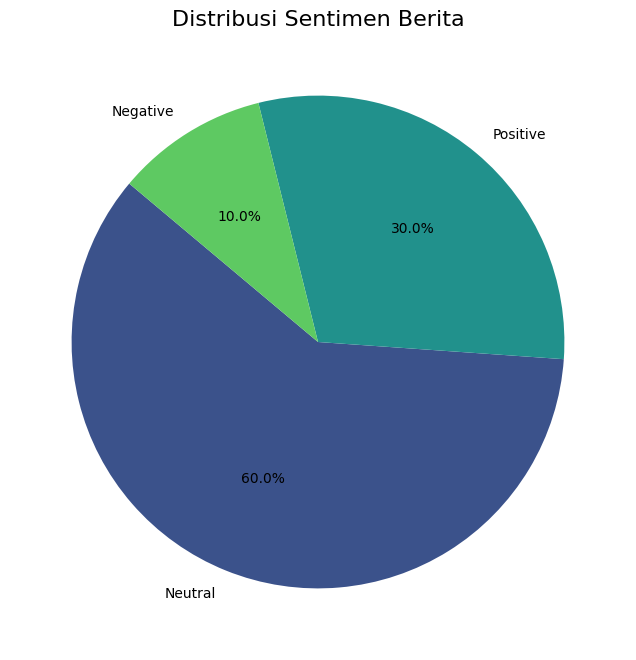


2. Interpretasi Insight:
- Dari sampel yang dianalisis, mayoritas berita (60.0%) memiliki sentimen 'Neutral'.
- Tingginya jumlah sentimen 'Netral' menunjukkan bahwa sebagian besar berita disajikan secara faktual tanpa opini yang kuat, yang merupakan ciri khas jurnalisme yang baik.
- Adanya berita dengan sentimen 'Negatif' dapat menjadi indikator topik-topik yang sedang menjadi perhatian atau masalah di masyarakat.

--- Conclusion & Recommendations ---

Berdasarkan insight di atas, berikut adalah contoh rekomendasi:
- Untuk Strategi Marketing: Fokus pada berita bersentimen 'Positif' untuk materi promosi. Analisis berita 'Negatif' dapat digunakan untuk manajemen krisis atau memahami keluhan pasar.
- Untuk Tim Redaksi: Visualisasi sentimen ini dapat menjadi alat bantu untuk mengevaluasi keberimbangan pemberitaan dan memastikan objektivitas konten yang dipublikasikan.


In [7]:
# ==============================================================================
# Langkah 7: Insight, Visualisasi, dan Rekomendasi
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\nMemulai tahap analisis hasil untuk menemukan insight...")

# Memastikan kita bekerja dengan DataFrame yang sudah ada hasilnya
if 'df_sample' in locals() and 'sentiment' in df_sample.columns:

    # 1. Menghitung distribusi sentimen
    sentiment_counts = df_sample['sentiment'].value_counts()
    print("\n--- Insight & Findings ---")
    print("\n1. Distribusi Sentimen dari Sampel Berita:")
    print(sentiment_counts)

    # 2. Membuat Visualisasi (Pie Chart)
    plt.figure(figsize=(8, 8))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(sentiment_counts)))
    plt.title('Distribusi Sentimen Berita', fontsize=16)
    plt.ylabel('') # Menghilangkan label 'sentiment' di samping chart
    plt.show()

    # 3. Menulis Insight Berdasarkan Data
    # (Ini adalah contoh interpretasi yang bisa Anda kembangkan)
    print("\n2. Interpretasi Insight:")
    # Mencari sentimen mayoritas
    mayoritas_sentimen = sentiment_counts.idxmax()
    persentase = sentiment_counts.max() / sentiment_counts.sum() * 100
    print(f"- Dari sampel yang dianalisis, mayoritas berita ({persentase:.1f}%) memiliki sentimen '{mayoritas_sentimen}'.")
    if 'Neutral' in sentiment_counts:
        print("- Tingginya jumlah sentimen 'Netral' menunjukkan bahwa sebagian besar berita disajikan secara faktual tanpa opini yang kuat, yang merupakan ciri khas jurnalisme yang baik.")
    if 'Negative' in sentiment_counts:
        print("- Adanya berita dengan sentimen 'Negatif' dapat menjadi indikator topik-topik yang sedang menjadi perhatian atau masalah di masyarakat.")

    # 4. Merumuskan Rekomendasi
    print("\n--- Conclusion & Recommendations ---")
    print("\nBerdasarkan insight di atas, berikut adalah contoh rekomendasi:")
    print("- Untuk Strategi Marketing: Fokus pada berita bersentimen 'Positif' untuk materi promosi. Analisis berita 'Negatif' dapat digunakan untuk manajemen krisis atau memahami keluhan pasar.")
    print("- Untuk Tim Redaksi: Visualisasi sentimen ini dapat menjadi alat bantu untuk mengevaluasi keberimbangan pemberitaan dan memastikan objektivitas konten yang dipublikasikan.")

else:
    print("\nAnalisis belum dijalankan. Mohon jalankan langkah-langkah sebelumnya terlebih dahulu.")